In [1]:
import torch
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")
from torch import nn, optim
from torch.nn import functional as F
from src.datasets.dataset_wrappers import AugRepresentationDataset
from IPython.display import display,clear_output
import tqdm
from sklearn.metrics import normalized_mutual_info_score as nmi
import umap

In [2]:
#import the data
org = torch.load("../originals.pt")
aug = torch.load("../augmentations.pt")
labels = torch.load("../labels.pt")
nn_indices = torch.load("../nn_indices.pt")
dataset = AugRepresentationDataset(aug,org,labels)



In [3]:
reducer = umap.UMAP(n_components=2,random_state=42,metric="cosine")
reducer.fit(org)
embedding = reducer.transform(F.normalize(org,dim=1))
embedding.shape


/home/alex/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(42443, 2)

<Axes: >

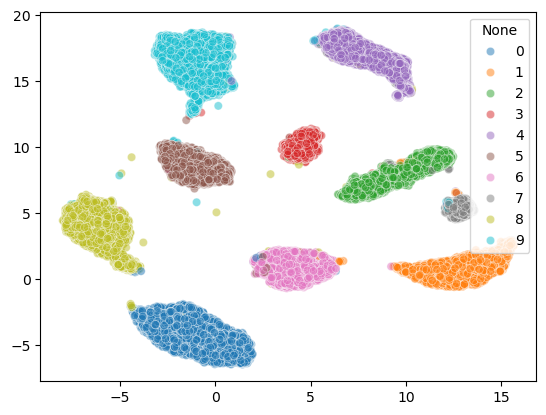

In [4]:
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],hue=labels,alpha=0.5,palette="tab10")

In [5]:
class protoclassifier(nn.Module):
    def __init__(self):
        super(classifier,self).__init__()
        self.block = nn.Sequential(
            nn.Linear(512,512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(512,512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(512,512)
        )
        
        self.proto_vect = nn.Parameter(torch.randn(512,10))
    def forward(self,x):

        if x.ndim==3:
            bs = x.shape[0]
            x = x.reshape(-1,x.shape[2])
            x = self.block(x)
            x = x.reshape(bs,-1,512)
        else:
            x = self.block(x)
        return x



class classifier(nn.Module):
    def __init__(self):
        super(classifier,self).__init__()
        self.block = nn.Sequential(
            nn.Linear(512,512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(512,512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(512,10)
        )
        
        
    def forward(self,x):

        if x.ndim==3:
            bs = x.shape[0]
            x = x.reshape(-1,x.shape[2])
            x = self.block(x)
            x = x.reshape(bs,-1,10)
        else:
            x = self.block(x)
        return x




In [6]:
def MI_loss(logits,lamb=1.0,tau=1.0,eps=1e-10):
    "logits are shape (bs,n,k)"
    bs,n,k = logits.shape

    p = F.softmax(logits,dim=2)

    #compute the estimate of the 
    #joint probability distribution
    J = torch.einsum('bik,bjc->ijkc',p,p) 
    J = J.mean(dim=(0,1)) / bs  #shape (k,k) / 

    #marginal probabilities
    P1 = J.mean(dim=0).unsqueeze(1)
    P2 = J.mean(dim=1).unsqueeze(0)
    
    logk = torch.log(torch.tensor(k))
    Joint_entropy = - (J * torch.log(J + eps)).sum() / logk  # positive 
    Marginal_entropy = - (J * torch.log(P1*P2 + eps)).sum() / logk  # positive

    #compute the loss
    return Joint_entropy - Marginal_entropy*lamb 

def FCE_loss(logits,tau=1.0,eps=1e-10):

    bs,n,k = logits.shape

    p = F.softmax(logits,dim=2)
    
    #compute the shared class fuzzy estimate
    B = torch.einsum('bik,cjk->ijbc',p,p)
    B = B.mean(dim=(0,1)) #shape (bs,bs)
    
    #get the negative targets
    N = B.tril(diagonal=-1)
    N = 1-N +eps
    #assume the negative targets come from a 
    #distribution that has mean 1/k 
    neg_targets = torch.zeros_like(N)
    neg_targets = 1-neg_targets.tril(diagonal=-1)

    #compute the negative loss
    #compute a contrastive loss 
    Pos_pair_CE = -torch.log(B.diagonal()).sum()
    Neg_pair_CE = -(neg_targets*torch.log(N)).sum()

    return Pos_pair_CE + tau * Neg_pair_CE

def fce_loss(logits, tau=1.0, eps=1e-4):
    """
    Fuzzy Contrastive Entropy (FCE) Loss.
    This loss function applies the principles of contrastive learning by comparing
    the average cluster assignments of instances in the batch.

    Args:
        logits (torch.Tensor): The output from the network. Shape: (bs, n, k)
                               bs = batch size, n = num augmentations, k = num clusters.
        tau (float): A weighting factor for the negative pair loss.
        eps (float): Small value for numerical stability.
    """
    bs, n, k = logits.shape

    # Apply softmax to get probability distributions for each augmentation
    p = F.softmax(logits, dim=2) # Shape: (bs, n, k)

    # Average the probabilities across augmentations for each instance.
    # This gives a single representative probability vector per instance.
    p_mean = p.mean(dim=1) # Shape: (bs, k)

    # --- Calculate the Similarity Matrix ---
    # We compute a (bs, bs) similarity matrix where S_ij is the dot product
    # between the mean probability vectors of instance i and instance j.
    similarity_matrix = torch.matmul(p_mean, p_mean.t()) # Shape: (bs, bs)
    
    # Clamp for stability
    similarity_matrix = torch.clamp(similarity_matrix, min=eps, max=1.0)

    # --- Positive Pair Loss ---
    # The positive loss encourages the diagonal elements of the similarity matrix
    # to be close to 1. This means the dot product of an instance's average
    # probability vector with itself should be high.
    pos_loss = -torch.log(similarity_matrix.diagonal()).mean()

    # --- Negative Pair Loss ---
    # The negative loss encourages the off-diagonal elements to be close to 0.
    # This pushes the average representations of different instances apart.
    neg_mask = 1 - torch.eye(bs, device=logits.device)
    neg_sim = similarity_matrix * neg_mask
    
    # Minimize similarity, so minimize -log(1 - similarity)
    neg_loss = -torch.log(1 - neg_sim[neg_mask > 0] + eps).mean()

    return (pos_loss + tau * neg_loss)


def swav_loss(predictions, model, temperature=0.1, sinkhorn_epsilon=0.05, sinkhorn_iterations=3):
    """
    SwAV (Swapping Assignments between multiple Views) Loss.
    This loss encourages consistency by predicting the cluster assignment (code) of
    one view from the representation of another view.

    Args:
        predictions (torch.Tensor): The output features from the network. Shape: (bs, n, d)
                                    bs = batch size, n = num augmentations, d = feature dim.
        model (torch.nn.Module): The model, which must contain a `proto_vect` attribute
                                 of shape (d, k) representing the cluster prototypes.
        temperature (float): Temperature for the final softmax.
        sinkhorn_epsilon (float): Epsilon for the Sinkhorn-Knopp algorithm.
        sinkhorn_iterations (int): Number of iterations for Sinkhorn-Knopp.
    """
    bs, n, d = predictions.shape
    
    # Get and normalize prototypes
    prototypes = F.normalize(model.proto_vect, dim=0, p=2) # Shape: (d, k)
    
    # Normalize the predictions (features)
    predictions = F.normalize(predictions, dim=2, p=2) # Shape: (bs, n, d)

    # --- Compute Scores and Target Codes (Q) ---
    # 1. Calculate the dot product of all features with all prototypes
    all_scores = torch.einsum('bnd,dk->bnk', predictions, prototypes) # Shape: (bs, n, k)
    
    # 2. Use Sinkhorn-Knopp to get optimal transport-based cluster assignments (codes)
    # This is done on the entire batch of augmentations at once.
    with torch.no_grad():
        q = all_scores.view(-1, prototypes.shape[1]) # Shape: (bs*n, k)
        q = torch.exp(q / sinkhorn_epsilon).t()
        q = q / q.sum()
        
        K, B = q.shape
        r = torch.ones(K, device=q.device) / K
        c = torch.ones(B, device=q.device) / B

        for _ in range(sinkhorn_iterations):
            
            q *= (r.unsqueeze(1) / q.sum(dim=1, keepdim=True))
            q *= (c / q.sum(dim=0, keepdim=True))
        
        # Final target codes, detached from the graph
        target_codes = (q / q.sum(dim=0, keepdim=True)).t().view(bs, n, -1) # Shape: (bs, n, k)

    # --- Compute Swapped Prediction Loss ---
    # The loss is the sum of cross-entropies between the target code of one view
    # and the predicted probabilities of another view.
    
    total_loss = 0.0
    
    # Get the log-probabilities for all views
    log_probs = F.log_softmax(all_scores / temperature, dim=2) # Shape: (bs, n, k)
    
    # Iterate through all pairs of views (i, j) where i != j
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            
            # Predict the code of view j using the features of view i
            loss = -torch.mean(torch.sum(target_codes[:, j, :] * log_probs[:, i, :], dim=1))
            total_loss += loss
            
    # Normalize by the number of pairs
    return total_loss / (n * (n - 1))

In [7]:
eye =torch.eye(5)
torch.tril(eye,diagonal=0).shape


torch.Size([5, 5])

In [8]:
model = classifier()
device='cuda'
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0003)
dataset = TensorDataset(aug,org,torch.tensor(embedding),labels)
dataloader = DataLoader(dataset,batch_size=2000,shuffle=True,drop_last=True)

nmi_scores = []
losses = []

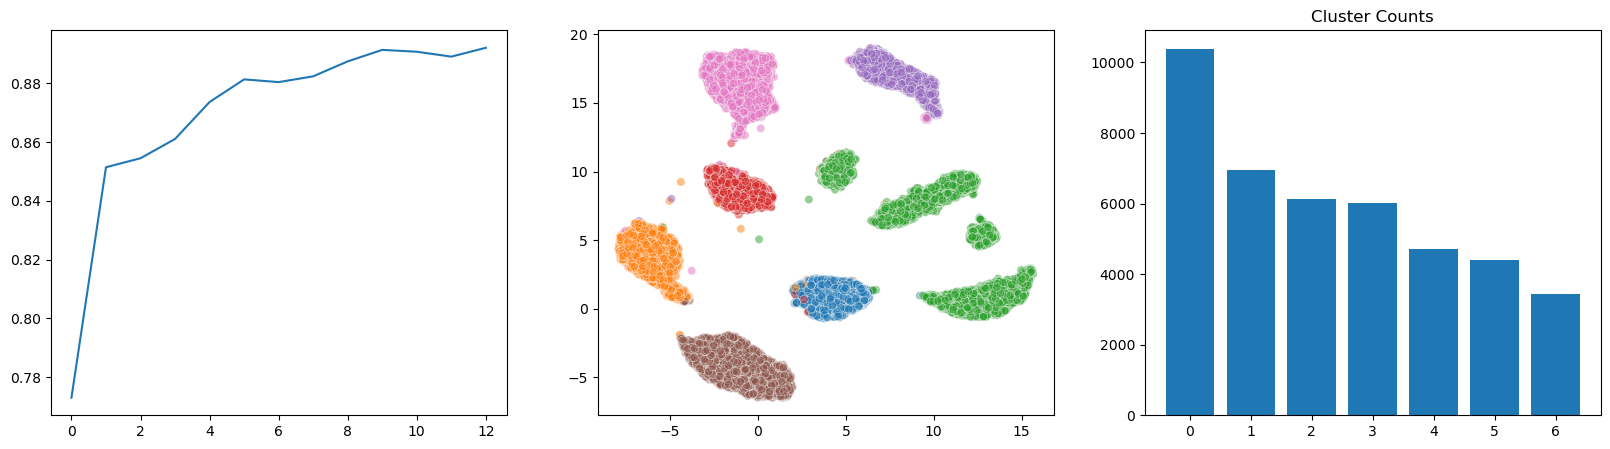

KeyboardInterrupt: 

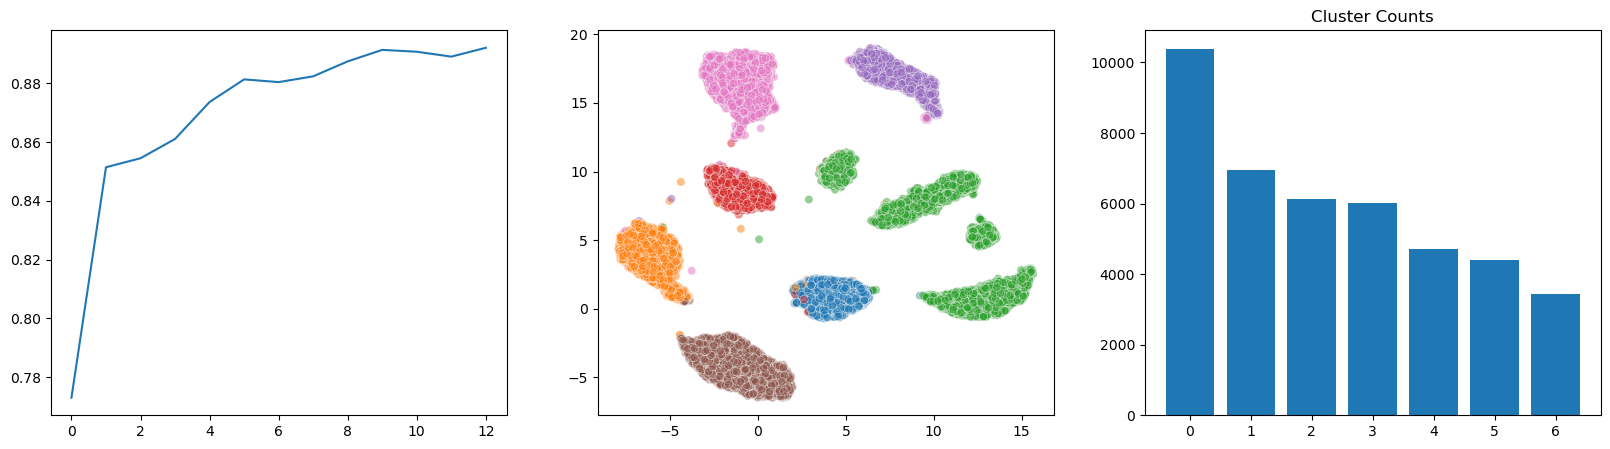

In [ ]:
model = classifier()
device='cuda'
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
dataset = TensorDataset(aug,org,torch.tensor(embedding),labels)
dataloader = DataLoader(dataset,batch_size=1000,shuffle=True,drop_last=True)

nmi_scores = []
losses = []
progress_bar = tqdm.notebook.trange(20)
f,a = plt.subplots(1,3,figsize=(20,5))
for epoch in progress_bar:
    predictions = []
    rand_labels = []
    temp_emb = []
    for batch in dataloader:
        xt,x,e,y = batch
        xt = xt[:,torch.randperm(10)[:5],:].to(device)
        p = model(xt)
        loss = MI_loss(p,lamb=0.2) + fce_loss(p,tau=0.5)
    

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        predictions.append(p.mean(dim=1).argmax(dim=1).cpu().numpy())
        rand_labels.append(y.cpu().numpy())
        losses.append(loss.item())
        temp_emb.append(e.cpu().numpy())

    temp_emb = np.concatenate(temp_emb)
    predictions = np.concatenate(predictions)
    rand_labels = np.concatenate(rand_labels)
    nmi_score = nmi(predictions,rand_labels)
    progress_bar.set_description(f"Epoch {epoch}, NMI: {nmi_score:.4f}")
    nmi_scores.append(nmi_score)
    clear_output(wait=True)
    for ax in a: ax.clear()
    sns.scatterplot(x=temp_emb[:,0],y=temp_emb[:,1],
                    hue=predictions,alpha=0.5,palette="tab10",
                    legend=False,ax=a[1])
    
    a[0].plot(nmi_scores)
    #make a sorted barplot of the labels
    counts = np.bincount(predictions)
    counts = np.sort(counts)[::-1]
    a[2].bar(range(len(counts)),counts)
    a[2].set_title("Cluster Counts")
    display(f)

    

In [ ]:
all_scores.shape

torch.Size([1000, 5, 20])

In [73]:
model.proto_vect.shape,p.shape

(torch.Size([512, 20]), torch.Size([1000, 5, 512]))

In [15]:
marginal

[-0.27436065460954395,
 -0.2751956901379994,
 -0.2750417540470759,
 -0.27491592509405954,
 -0.27415456374486286]

In [ ]:
p = p.detach().cpu()
p = torch.softmax(p,dim=2)

In [128]:
J = torch.einsum('bik,bjc->ijkc',p,p)



In [130]:
J[0,0].sum()

tensor(1000.0001)

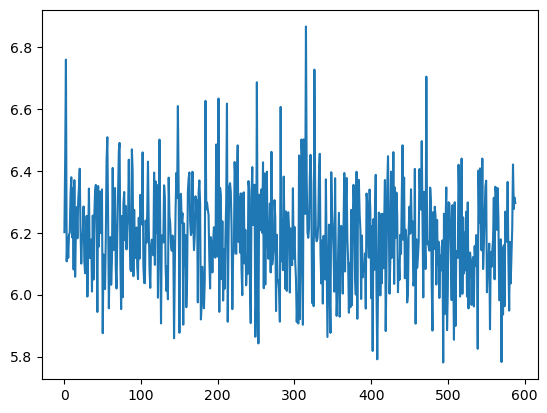

In [102]:
dataloader = DataLoader(dataset,batch_size=128,shuffle=False)
with torch.no_grad():
    model.eval()
    predictions = []
    rand_labels = []
    for batch in dataloader:
        _,x,y = batch
        x = x.to(device)
        p = model(x)
        predictions.append(p.argmax(dim=1).cpu().numpy())
    
    predictions = np.concatenate(predictions)


<Axes: >

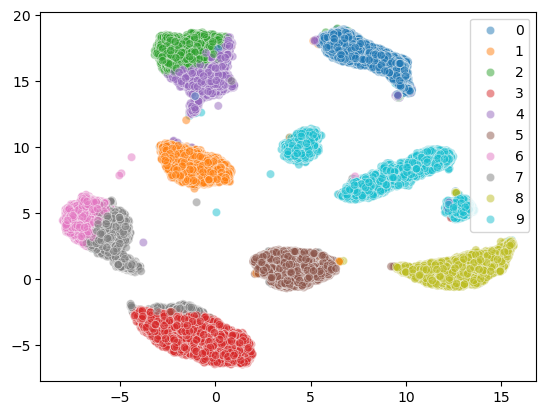

In [103]:
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],hue=predictions,alpha=0.5,palette="tab10")